In [1]:
import wfdb
import csv
import pandas as pd
import numpy as np
import os

In [2]:
import os
import csv
import pandas as pd
import wfdb  # Make sure wfdb is installed

output_dir = "data_creation"
os.makedirs(output_dir, exist_ok=True)

# Patient numbers
patient_numbers = [
    "100", "101", "102", "103", "104", "105", "106", "107", "108", "109",
    "111", "112", "113", "114", "115", "116", "117", "118", "119", "121",
    "122", "123", "124", "200", "201", "202", "203", "205", "207", "208",
    "209", "210", "212", "213", "214", "215", "217", "219", "220", "221",
    "222", "223", "228", "230", "231", "232", "233", "234"
]

# N = normal 
# S = supra-ventricular premature
# V = ventricular escape
# F = fusion of ventricular and normal
# Q = unclassified heartbeats
symbol_to_category = {
    'N': 'N', '.': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',
    'a': 'S', 'A': 'S', 'J': 'S', 'S': 'S',
    'V': 'V', 'E': 'V',
    'F': 'F',
    '/': 'Q', 'f': 'Q', 'Q': 'Q'
}

for patient_number in patient_numbers:
    try:
        # ECG data
        path_to_record = f"mit-database/{patient_number}"
        patient_record = wfdb.rdrecord(path_to_record)
        leads = patient_record.sig_name
        ecg_data = patient_record.p_signal

        # ECG CSV
        ecg_filename = f"{output_dir}/{patient_number}_ECG.csv"
        with open(ecg_filename, "w", newline='') as outfile:
            out_csv = csv.writer(outfile)
            out_csv.writerow(leads)
            for row in ecg_data:
                out_csv.writerow(row)

        # Annotations data
        annotation = wfdb.rdann(path_to_record, 'atr')
        symbols = annotation.symbol
        annotations = annotation.sample

        # Filter out symbols not in symbol_to_category
        filtered_symbols_annotations = [(sym, ann) for sym, ann in zip(symbols, annotations) if sym in symbol_to_category]
        categories = [symbol_to_category[sym] for sym, ann in filtered_symbols_annotations]
        annotations_filtered = [ann for sym, ann in filtered_symbols_annotations]

        df_annotations = pd.DataFrame({'Category': categories, 'Annotation': annotations_filtered})

        # Annotations CSV
        annotations_filename = f"{output_dir}/{patient_number}_Annotations.csv"
        df_annotations.to_csv(annotations_filename, index=False)

    except Exception as e:
        print(f"Failed to process: {patient_number}: {e}")

print("Done")

Done


In [3]:
import os
import pandas as pd
import numpy as np


def process_patient_data(patient_number, data_creation_dir="data_creation"):
    ecg_file_path = os.path.join(data_creation_dir, f"{patient_number}_ECG.csv")
    annotations_file_path = os.path.join(data_creation_dir, f"{patient_number}_Annotations.csv")
    
    patient_X = []
    patient_Y = []
    
    try:
        ecg_df = pd.read_csv(ecg_file_path)
        annotations_df = pd.read_csv(annotations_file_path)
    except FileNotFoundError:
        print(f"Files for patient {patient_number} not found. Skipping...")
        return [], []
    
    first_column_name = ecg_df.columns[0]
    second_column_name = ecg_df.columns[1] if len(ecg_df.columns) > 1 else None

    sampling_rate = 360  # Hz
    total_window_size_seconds = 1  # Total window size in seconds
    total_window_size_samples = total_window_size_seconds * sampling_rate

    for _, row in annotations_df.iterrows():
        annotation_point = row['Annotation']
        category = row['Category']
        
        # Randomly determine the window split around the annotation point
        before_seconds = np.random.uniform(0, total_window_size_seconds)
        after_seconds = total_window_size_seconds - before_seconds
        before_samples = int(before_seconds * sampling_rate)
        after_samples = int(after_seconds * sampling_rate)
        
        start_point = max(0, annotation_point - before_samples)
        end_point = start_point + total_window_size_samples  # Ensure the window is of the exact expected size
        
        # Adjust the end point if it exceeds the length of the data
        if end_point > len(ecg_df):
            end_point = len(ecg_df)
            start_point = max(0, end_point - total_window_size_samples)  # Adjust start point accordingly
        
        # Process data from the first column
        window_data_first_column = ecg_df.iloc[start_point:end_point][first_column_name].to_numpy()
        
        patient_X.append(window_data_first_column)
        patient_Y.append(category)
        
        # If there's a second column, process it and add as a new entry
        if second_column_name:
            window_data_second_column = ecg_df.iloc[start_point:end_point][second_column_name].to_numpy()
            
            patient_X.append(window_data_second_column)
            patient_Y.append(category)  # Repeat category for the new entry
    
    return patient_X, patient_Y



# Initialize lists to hold the entire dataset
all_X = []
all_Y = []

data_creation_dir = "data_creation"

# Process each patient
for patient_number in patient_numbers:
    patient_X, patient_Y = process_patient_data(patient_number, data_creation_dir)
    all_X.extend(patient_X)
    all_Y.extend(patient_Y)

X = np.array(all_X)
Y = np.array(all_Y)

In [4]:
X

array([[-0.145, -0.145, -0.145, ..., -0.445, -0.475, -0.51 ],
       [-0.065, -0.065, -0.065, ..., -0.36 , -0.355, -0.305],
       [-0.255, -0.245, -0.255, ..., -0.35 , -0.34 , -0.33 ],
       ...,
       [ 0.065,  0.08 ,  0.095, ..., -0.095, -0.045, -0.01 ],
       [-0.15 , -0.155, -0.16 , ..., -0.395, -0.38 ,  0.   ],
       [ 0.   , -0.015, -0.005, ...,  0.075,  0.08 ,  0.   ]])

In [5]:
Y

array(['N', 'N', 'N', ..., 'N', 'N', 'N'], dtype='<U1')

In [6]:
df_x = pd.DataFrame(X)
df_x

,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,359
0,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.120,-0.135,...,-0.325,-0.330,-0.350,-0.365,-0.360,-0.380,-0.425,-0.445,-0.475,-0.510
1,-0.065,-0.065,-0.065,-0.065,-0.065,-0.065,-0.065,-0.065,-0.080,-0.080,...,-0.235,-0.250,-0.270,-0.280,-0.290,-0.300,-0.330,-0.360,-0.355,-0.305
2,-0.255,-0.245,-0.255,-0.250,-0.250,-0.265,-0.260,-0.260,-0.265,-0.270,...,-0.345,-0.345,-0.330,-0.330,-0.335,-0.345,-0.350,-0.350,-0.340,-0.330
3,-0.155,-0.160,-0.170,-0.155,-0.155,-0.150,-0.165,-0.175,-0.165,-0.165,...,-0.220,-0.210,-0.205,-0.200,-0.205,-0.220,-0.230,-0.215,-0.205,-0.200
4,-0.470,-0.475,-0.460,-0.450,-0.445,-0.440,-0.435,-0.440,-0.410,-0.395,...,-0.355,-0.350,-0.340,-0.355,-0.350,-0.365,-0.365,-0.350,-0.355,-0.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218983,0.070,0.080,0.095,0.080,0.075,0.090,0.090,0.095,0.080,0.080,...,0.010,-0.005,0.015,0.055,0.145,0.245,0.375,0.480,0.570,0.600
218984,-0.270,-0.270,-0.265,-0.250,-0.260,-0.260,-0.250,-0.250,-0.245,-0.240,...,0.945,0.590,0.260,0.005,-0.180,-0.285,-0.330,-0.330,-0.305,-0.280
218985,0.065,0.080,0.095,0.100,0.100,0.110,0.110,0.115,0.125,0.100,...,0.490,0.345,0.185,0.040,-0.060,-0.135,-0.135,-0.095,-0.045,-0.010
218986,-0.150,-0.155,-0.160,-0.155,-0.165,-0.165,-0.180,-0.190,-0.200,-0.205,...,-0.350,-0.350,-0.350,-0.365,-0.390,-0.390,-0.390,-0.395,-0.380,0.000


In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_x = scaler.fit_transform(df_x)
df_x = pd.DataFrame(df_x)


In [8]:
import pywt

def madev(d, axis=None):
    'Mean absolute deviation of a signal'
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def wavelet_denoising(x, wavelet='sym4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')


df_x = wavelet_denoising(df_x, wavelet='sym4', level=2)
df_x = pd.DataFrame(df_x)


In [9]:
df_y = pd.DataFrame(Y, columns=['ColumnName'])
print(df_y)

       ColumnName
0               N
1               N
2               N
3               N
4               N
...           ...
218983          N
218984          N
218985          N
218986          N
218987          N

[218988 rows x 1 columns]


In [10]:
value_counts_y = df_y['ColumnName'].value_counts()
print(value_counts_y)

ColumnName
N    181262
Q     16086
V     14472
S      5562
F      1606
Name: count, dtype: int64


In [11]:
df_fusionné = pd.concat([df_y, df_x], axis=1)
df_fusionné

,ColumnName,0,1,2,3,4,5,6,7,8,...,350,351,352,353,354,355,356,357,358,359
0,N,0.462802,0.482683,0.484201,0.480622,0.483115,0.486397,0.486589,0.485916,0.486573,...,0.465106,0.465147,0.464962,0.464551,0.465856,0.467060,0.465541,0.464482,0.457253,0.448988
1,N,0.482763,0.483015,0.483146,0.483103,0.483948,0.485089,0.486187,0.487332,0.488474,...,0.481544,0.483960,0.481614,0.477985,0.472878,0.467947,0.469104,0.472385,0.476706,0.481401
2,N,0.469669,0.470015,0.470370,0.470744,0.471131,0.471511,0.471911,0.472293,0.472561,...,0.468262,0.468371,0.468483,0.468598,0.468742,0.468897,0.469013,0.469137,0.469251,0.469389
3,N,0.481224,0.481429,0.481634,0.481844,0.482059,0.482267,0.482481,0.482680,0.482807,...,0.480132,0.480210,0.480303,0.480402,0.480519,0.480641,0.480742,0.480845,0.480942,0.481049
4,N,0.461350,0.461318,0.461318,0.461351,0.461406,0.461488,0.461599,0.461737,0.461889,...,0.463451,0.463187,0.462920,0.462659,0.462421,0.462198,0.461978,0.461777,0.461589,0.461430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218983,N,0.507810,0.510709,0.506070,0.511043,0.508758,0.506236,0.507426,0.509641,0.509223,...,0.497761,0.495000,0.501383,0.511623,0.516839,0.520525,0.535194,0.548073,0.551798,0.559685
218984,N,0.477806,0.474877,0.471826,0.468868,0.469752,0.471903,0.474733,0.477692,0.478061,...,0.588972,0.551300,0.526870,0.508537,0.487658,0.469867,0.465267,0.466208,0.471497,0.478614
218985,N,0.508942,0.507969,0.506532,0.504778,0.505821,0.507657,0.509701,0.511706,0.511920,...,0.542740,0.532233,0.521273,0.511022,0.497620,0.485440,0.485824,0.490835,0.498691,0.507551
218986,N,0.487045,0.486655,0.485669,0.483988,0.483587,0.483502,0.483030,0.482543,0.482392,...,0.466317,0.466687,0.464517,0.462251,0.458317,0.455057,0.459646,0.466776,0.475745,0.484839


In [12]:
line = df_fusionné.loc[df_fusionné['ColumnName'] == 'F']
line

,ColumnName,0,1,2,3,4,5,6,7,8,...,350,351,352,353,354,355,356,357,358,359
35688,F,0.460372,0.461933,0.463434,0.464994,0.466824,0.468644,0.470596,0.472404,0.473204,...,0.454479,0.453939,0.454049,0.454474,0.455136,0.455966,0.456634,0.457355,0.458139,0.459036
35689,F,0.450810,0.449831,0.448987,0.448296,0.447491,0.446681,0.445979,0.445302,0.444519,...,0.466210,0.467371,0.466752,0.465299,0.463659,0.461698,0.459523,0.457292,0.454734,0.452234
36800,F,0.487768,0.486230,0.480795,0.483829,0.482436,0.481479,0.484281,0.488109,0.488151,...,0.537735,0.536572,0.533751,0.530287,0.524940,0.519486,0.516498,0.511502,0.517116,0.531698
36801,F,0.529076,0.529369,0.532712,0.523132,0.526271,0.530792,0.530261,0.528490,0.529650,...,0.466038,0.467148,0.464087,0.460692,0.457155,0.454571,0.461060,0.474755,0.475913,0.464594
38328,F,0.471134,0.472090,0.472848,0.473388,0.475085,0.477134,0.479157,0.481196,0.482950,...,0.475601,0.463071,0.456029,0.452446,0.450431,0.450455,0.452986,0.456766,0.462590,0.468855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210255,F,0.519728,0.519317,0.518786,0.518448,0.519170,0.520346,0.522327,0.524666,0.525766,...,0.520210,0.520557,0.520473,0.520238,0.519871,0.519486,0.519436,0.519469,0.519744,0.520053
210556,F,0.523160,0.523878,0.528201,0.522390,0.522828,0.523081,0.518815,0.513353,0.512235,...,0.478331,0.479592,0.477770,0.475558,0.473574,0.472131,0.476171,0.485368,0.483962,0.472797
210557,F,0.500698,0.500758,0.500853,0.501056,0.501344,0.501631,0.502063,0.502448,0.502270,...,0.506550,0.507462,0.507229,0.506518,0.505772,0.504891,0.503948,0.503030,0.501957,0.500962
212980,F,0.471291,0.472059,0.472744,0.473350,0.474164,0.475011,0.475829,0.476610,0.477237,...,0.463795,0.462865,0.462551,0.462719,0.463119,0.463838,0.465086,0.466559,0.468372,0.470232


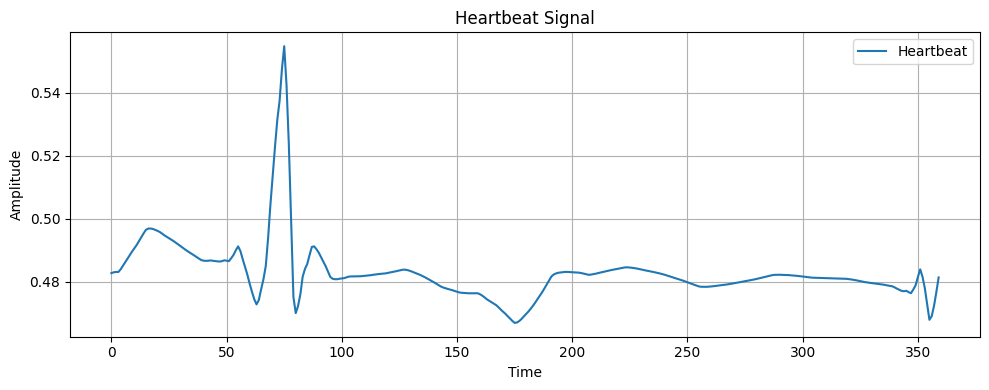

In [14]:
import matplotlib.pyplot as plt
import numpy as np

heartbeat_values = df_fusionné.iloc[1,1:]

time_axis = np.arange(0, 360)

# Plotting the heartbeat
plt.figure(figsize=(10, 4))
plt.plot(time_axis, heartbeat_values, label='Heartbeat')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Heartbeat Signal')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

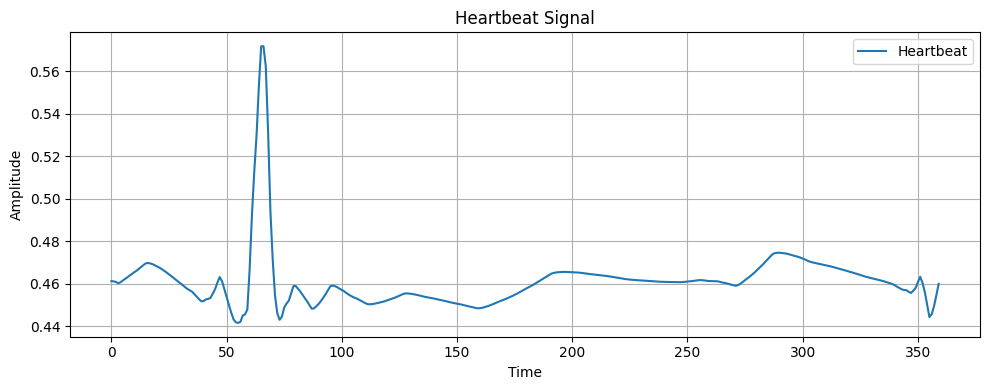

In [23]:
import matplotlib.pyplot as plt
import numpy as np

heartbeat_values = df_fusionné.iloc[100,1:]
heartbeat_values
# Creating a time axis for the 3600 points, assuming each point represents a unit of time
time_axis = np.arange(0, 360)

# Plotting the heartbeat
plt.figure(figsize=(10, 4))
plt.plot(time_axis, heartbeat_values, label='Heartbeat')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Heartbeat Signal')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()